In [2]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

# Read the data

In [3]:
train_test_path = "../../data_for_modeling/train_test_data/HDAC2_train_test_data_final.xlsx"
train_dataset = pd.read_excel(train_test_path, sheet_name='train_dataset')
test_dataset = pd.read_excel(train_test_path, sheet_name='test_dataset')
validation_dataset = pd.read_excel(train_test_path, sheet_name='validation_dataset')

In [4]:
all_dataset = pd.concat([train_dataset, test_dataset, validation_dataset], axis=0)

In [5]:
print(len(train_dataset), len(test_dataset), len(validation_dataset), len(all_dataset))

2016 281 504 2801


In [6]:
train_dataset.head()

,CID,SMILES,AVG_IC50_nM,FINAL_LABEL,ZBG Classified
0,44138033,COC(=O)c1ccc(CO/N=C/c2ccc(/C=C/C(=O)NO)cc2)cc1,15800.0,Inactive,1
1,164616411,CC[C@H](NC(=O)C1CN(C)C1)c1ncc(-c2cc3ccccc3nc2O...,50000.0,Inactive,15
2,135357843,O=C(NO)c1ccc(Cn2nnnc2-c2cccs2)cc1,3698.0,Inactive,1
3,142506189,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(NCc3ccc(C(...,7173.0,Inactive,1
4,155537112,CN(C)c1ccc(C(=O)N(CC(=O)NCc2ccccc2)Cc2ccc(C(=O...,283.0,Inactive,4


# Tanimoto coefficient

### Functions

In [6]:
from tqdm import tqdm

#MACCS
def maccs_fpts(data):
    Maccs_fpts = []
    count = 0
    with tqdm(total=len(data), desc='Progress') as pbar:
        for i in data:
            try:
                mol = Chem.MolFromSmiles(i)
            except:
                print("An exception occurred with " + str(count))
                continue
            fpts = MACCSkeys.GenMACCSKeys(mol)
            mfpts = np.array(fpts)
            Maccs_fpts.append(mfpts)
            count += 1
            pbar.update(1)  # Update the progress bar
    return np.array(Maccs_fpts)

#Morgan2
def morgan_fpts(data):
    Morgan_fpts = []
    count = 0
    with tqdm(total=len(data), desc='Progress') as pbar:
        for i in data:
            try:
                mol = Chem.MolFromSmiles(i)
            except:
                print("An exception occurred with " + str(count))
                continue
            fpts = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
            mfpts = np.array(fpts)
            Morgan_fpts.append(mfpts)
            count += 1
            pbar.update(1)  # Update the progress bar
    return np.array(Morgan_fpts)

In [7]:
def calculate_tanimoto_coefficient(array1, array2):
    if len(array1) != len(array2):
        raise ValueError("The arrays must have the same length.")
    
    # Calculate the Tanimoto coefficient
    intersection = sum(a and b for a, b in zip(array1, array2))
    union = sum(a or b for a, b in zip(array1, array2))
    
    if union == 0:  # Handle the case when both arrays are all zeros
        return 0.0
    else:
        tanimoto_coefficient = intersection / union
        return tanimoto_coefficient
    
def calculate_tc_among_dataset(encoded_dataset):
    size = len(encoded_dataset)
    result_matrix = np.zeros((size, size))
    for i in range(0, size):
        for j in range(i, size):
            result_matrix[i][j] = calculate_tanimoto_coefficient(encoded_dataset[i], encoded_dataset[j])
    return result_matrix

def set_zero_diagonal(numpy_matrix):
    col_idx = 0
    for i in range(0, numpy_matrix.shape[0]):
        numpy_matrix[i][col_idx] = 0
        col_idx+=1
    return numpy_matrix

In [14]:
#test Tc calculation function
from rdkit import DataStructs
i, j = 1, 4

compound0 = train_dataset.loc[i]['SMILES']
compound1 = train_dataset.loc[j]['SMILES']
compound0_mol = Chem.MolFromSmiles(compound0)
compound1_mol = Chem.MolFromSmiles(compound1)
test_compound0_morgan2 = AllChem.GetMorganFingerprintAsBitVect(compound0_mol, 2, 1024)
test_compound1_morgan2 = AllChem.GetMorganFingerprintAsBitVect(compound1_mol, 2, 1024) 

print("From Rdkit: " ,DataStructs.FingerprintSimilarity(test_compound0_morgan2, test_compound1_morgan2, metric=DataStructs.TanimotoSimilarity))
print("From my calculation: ", calculate_tanimoto_coefficient(test_compound0_morgan2, test_compound1_morgan2))

From Rdkit:  0.12121212121212122
From my calculation:  0.12121212121212122


In [9]:
all_dataset_morgan2 = morgan_fpts(all_dataset['SMILES'])
all_dataset_maccs = maccs_fpts(all_dataset['SMILES'])

Progress:   8%|▊         | 231/2801 [00:00<00:01, 2308.13it/s]

Progress: 100%|██████████| 2801/2801 [00:02<00:00, 1396.73it/s]


## Working with train and test dataset

### Morgan2

In [11]:
all_dataset_morgan2_tc = calculate_tc_among_dataset(all_dataset_morgan2)
# np.save("../../output/diversity_analysis/all_dataset_morgan2_tc.npy", all_dataset_morgan2_tc)
# all_dataset_morgan2_tc = np.load("../../output/diversity_analysis/all_dataset_morgan2_tc.npy")

<Axes: >

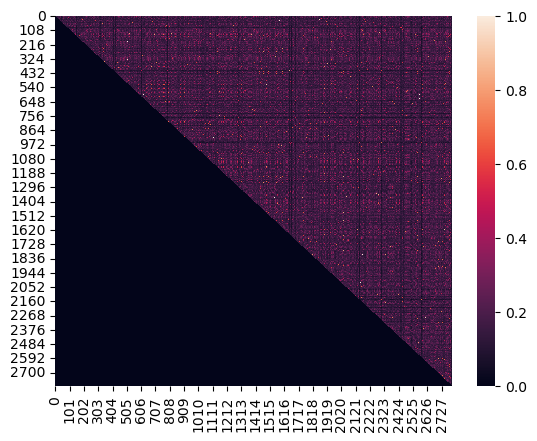

In [12]:
all_dataset_morgan2_tc = set_zero_diagonal(numpy_matrix=all_dataset_morgan2_tc)
sns.heatmap(all_dataset_morgan2_tc)

In [13]:
all_dataset_morgan2_tc_df = pd.DataFrame(all_dataset_morgan2_tc)
all_dataset_morgan2_tc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2791,2792,2793,2794,2795,2796,2797,2798,2799,2800
0,0.0,0.123596,0.200000,0.161616,0.162500,0.084112,0.100000,0.235294,0.205479,0.257143,...,0.181818,0.209677,0.159420,0.102804,0.176471,0.293333,0.142857,0.107527,0.186667,0.142857
1,0.0,0.000000,0.120879,0.209091,0.121212,0.353535,0.579545,0.159091,0.218391,0.177778,...,0.161905,0.192308,0.166667,0.431579,0.152941,0.150000,0.111111,0.120370,0.150538,0.177778
2,0.0,0.000000,0.000000,0.218750,0.187500,0.123810,0.118182,0.387097,0.232877,0.153846,...,0.164835,0.222222,0.413793,0.132075,0.261538,0.192771,0.088235,0.250000,0.338235,0.111111
3,0.0,0.000000,0.000000,0.000000,0.235294,0.155039,0.166667,0.244681,0.273684,0.163462,...,0.191304,0.200000,0.215054,0.161538,0.215054,0.171171,0.117021,0.133333,0.207921,0.120370
4,0.0,0.000000,0.000000,0.000000,0.000000,0.085470,0.100000,0.187500,0.269231,0.125000,...,0.352941,0.131579,0.137500,0.112069,0.181818,0.186813,0.106667,0.212766,0.190476,0.192771


## Calculate Histogram

In [52]:
def calculate_histogram(matrix, bin_size):
    histogram = {}
    n = len(matrix)
    for i in range(0, n):
        for j in range(i+1, n):
            element = matrix[i][j]
            # Find the bin range for the element
            bin_range = int(element / bin_size) * bin_size
            bin_range = round(bin_range, 2)
            if bin_range in histogram:
                histogram[bin_range] += 1
            else:
                histogram[bin_range] = 1
    sorted_histogram = {k: v for k, v in sorted(histogram.items())}
    # Separate keys and values into two arrays
    bin_values = list(sorted_histogram.keys())
    freq_values = list(sorted_histogram.values())
    return bin_values, freq_values

<Axes: >

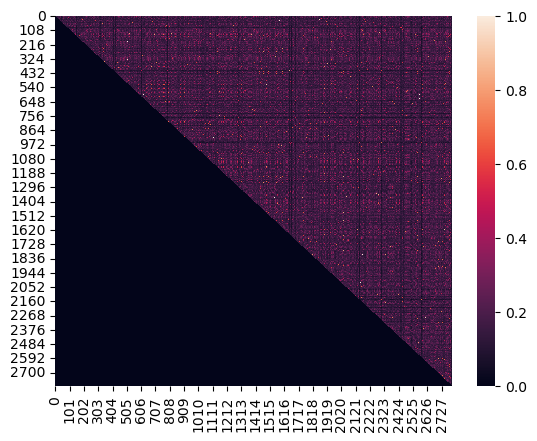

In [23]:
sns.heatmap(all_dataset_morgan2_tc)

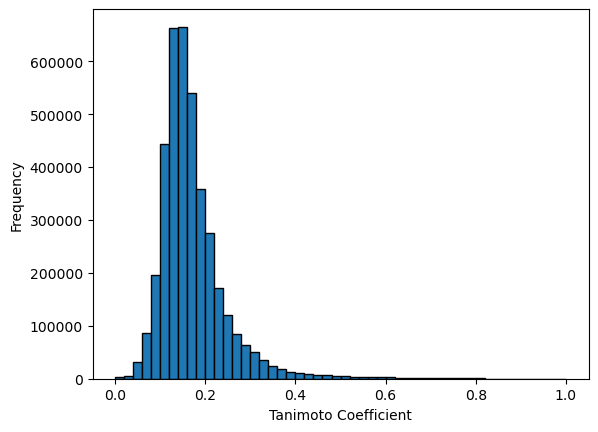

In [55]:
import numpy as np
import matplotlib.pyplot as plt
# Assuming all_dataset_morgan2_tc is a 2D array or matrix
matrix_size = len(all_dataset_morgan2_tc[0])  # Use the size of the first dimension
# Flatten the upper triangular matrix
flattened_matrix = all_dataset_morgan2_tc[np.triu_indices(matrix_size)]
# Plot histogram
plt.hist(flattened_matrix, bins=50, edgecolor='black')
# plt.title('Histogram of Tanimoto Coefficient between ')
plt.xlabel('Tanimoto Coefficient')
plt.ylabel('Frequency')

plt.show()

Convert into dataframe, if need futher visualization

In [55]:
bin_size = 0.01
bin_values, freq_values = calculate_histogram(all_dataset_morgan2_tc, bin_size)
histogram_morgan2 = {
    "Tanimoto coefficient": bin_values,
    "Frequency": freq_values
}
histogram_morgan2_df = pd.DataFrame.from_dict(histogram_morgan2)
histogram_morgan2_df

,Tanimoto coefficient,Frequency
0,0.00,288
1,0.01,419
2,0.02,930
3,0.03,3440
4,0.04,10532
...,...,...
95,0.95,17
96,0.96,9
97,0.97,31
98,0.98,16
